<a href="https://colab.research.google.com/github/erlenman/SOS/blob/master/4_Generalization_and_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalization and regularization

This practice has 3 main sections:


1.   Custom goal function
2.   Regularization
3.   Cross-validation

All examples with the same artificial regression data. I encourage you to try it on your dataset and classification task! 


In [0]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

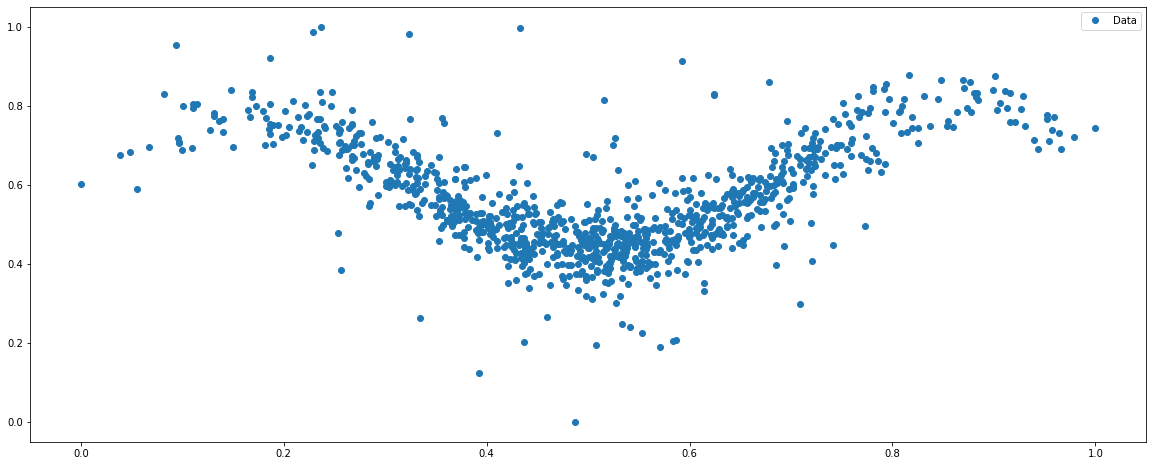

In [146]:
# Generate data with outliers.
# Don't hesitate to change the generation method and data itself! Observe, how it changes results

n_samples = 1000
n_outliers = 100

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=False, random_state=1110)



# Add outliers data

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

# Add non-linearity to data
y = y+100*X.T[0]*np.sin(X.T[0])

# Scale data to put in range [0,1] for stability.
# Try not to do it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())

plt.plot(X, y, 'o', label = 'Data')
plt.legend()

In [0]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

## Define Model

### Mean Absolute Percentage Error (MAPE)

Let's use [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a custom error function:

$$ \text{MAPE} = \mu \left| \frac{y_i - \hat{y_i}}{y_i} \right| 100$$

This function uses percentage ratio between error and original value to express forecast accuracy, which is much more interpretable, than absolute error. 

In [0]:
def mape(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape_value

In [149]:
print('Error of random prediction: %.2f%%'%mape(y, np.random.random(len(y))) )

Error of random prediction: 48.65%


In [0]:
def predict(X, theta):
    return np.dot(X, theta)

In [151]:
print('Error of random model: %.2f%%'%mape(y, predict(X_I, theta = np.random.random(len(X_I[0])))))

Error of random model: 111.47%


Define objective (goal) function as $L(\theta|X,y) = MAPE(y, h(\theta|X))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

In [0]:
def objective_function(theta, X,y, loss_function=mape):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)

#Try to add regularization term in the objective function

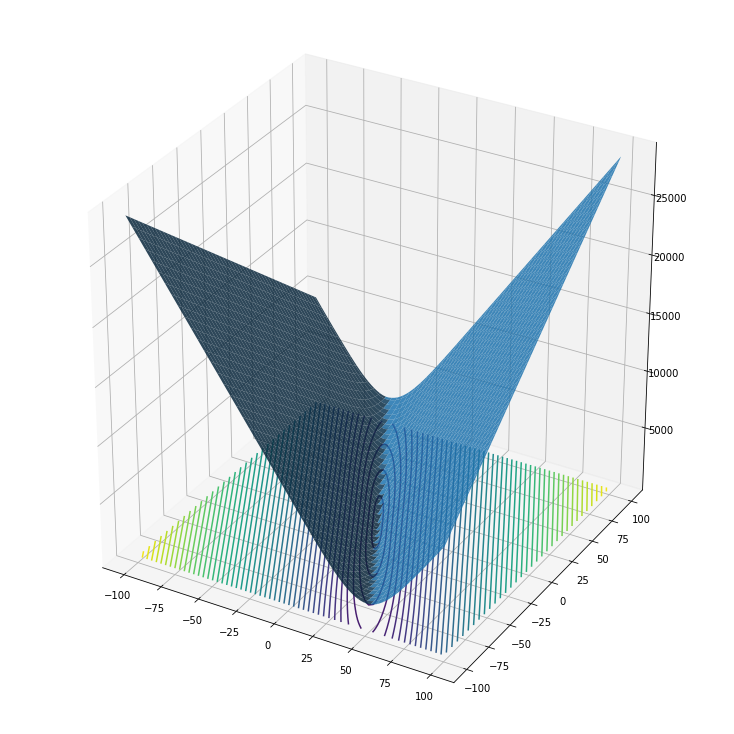

In [153]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b,w]), X_I, y, mape) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# create 2d array for each index 
K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

## Train model

It's enough to define gradient descent step manually!

There are less efficient but more universal approaches, for example use numerical optimization methods. 

Let's try [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [0]:
from scipy import optimize

In [0]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, mape), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',       # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC
                           options={}           # arguments of optimization method
                           )

In [156]:
result

   direc: array([[ 0.41799157, -0.65918525],
       [ 0.05534332, -0.12957704]])
     fun: 19.429144399816902
 message: 'Optimization terminated successfully.'
    nfev: 174
     nit: 5
  status: 0
 success: True
       x: array([ 0.52914218, -0.05731201])

Optimization results come in special object. Here what we are interested in:

In [157]:
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 19.429144399816902
Found theta: [ 0.52914218 -0.05731201]


The most common reason of optimization fail is _'Desired error not necessarily achieved due to precision loss'_. It means, that on some point the procedure became numerically unstable, usually because of too big or too small values of objective function. 

If this point wasn't too close, results are still usable. 

There is also some chance to make result better with changing _theta_init_  or just re-running the function. 

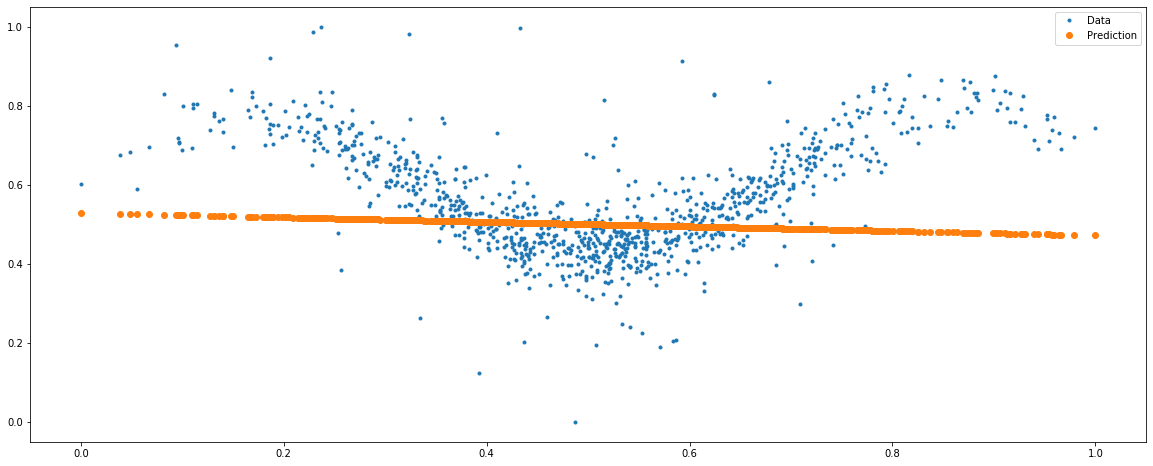

In [158]:
# Visualize result
theta = result.x
y_pred = predict(X_I, theta)
plt.plot(X, y, '.', label = 'Data')
plt.plot(X, y_pred, 'o', label = 'Prediction')
plt.legend()

In [0]:
from numpy.linalg import norm

def weighted_regression_objective(theta, X, y, x_i, sigma, loss):
  dist = np.array([norm(x_i - x, ord = 2) for x in X])
  weights = np.exp((dist/sigma)**2)
  
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  errors = loss(y_true, y_pred)
  weighted_errors = weights * errors
  return sum(weighted_errors)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_I, y, test_size = 0.2)

In [162]:
%%time
samples =  X_test
y_pred = []
theta_i = [1,1]
for x_i in samples:
  theta_i = optimize.minimize(
                  weighted_regression_objective,
                  args=(X_train, y_train, x_i, 0.15, mape), 
                  x0 = theta_i, 
                  method='CG', 
                  options={}).x
  
  y_pred_i = predict(x_i, theta_i)
  y_pred.append(y_pred_i)
y_pred = np.array(y_pred)

CPU times: user 1min 35s, sys: 51.6 ms, total: 1min 35s
Wall time: 1min 35s


In [163]:
x_i

array([1., 1.])

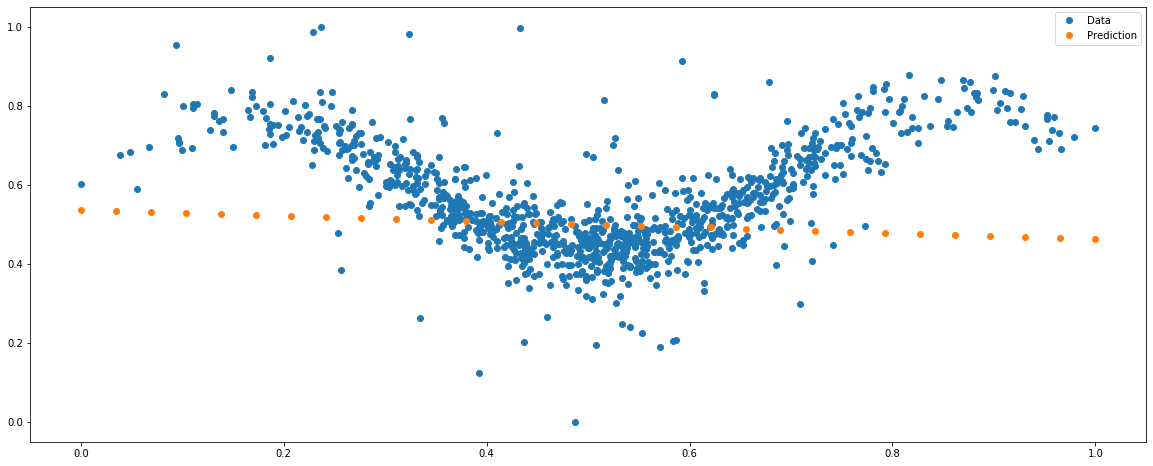

In [164]:
plt.plot(X, y, 'o', label = 'Data')
plt.plot(samples[:,1], y_pred, 'o', label = 'Prediction')
plt.legend()

In [0]:
# For further use, let's make universal function to train regression model with any objective and loss functions
def custom_regression(X, y, 
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init = 1, 
                      verbose = True, 
                      iters = 10):
  
  theta_init = np.ones_like(X[0]) * init
  result = optimize.minimize(objective_function,
                             args=(X, y, loss_function), 
                             x0 = theta_init, 
                             method='BFGS', 
                             options={'maxiter': iters})
  theta = result['x']
  if verbose:
    print(result['fun'])
  return theta

In [166]:
from sklearn.preprocessing import PolynomialFeatures

n = 10
polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
X_a = polynomial_features.fit_transform(X_I)
X_a.shape

(1000, 66)

In [167]:
theta = custom_regression(X_a, y, objective_function=objective_function, loss_function=mape)

12.863518758568521


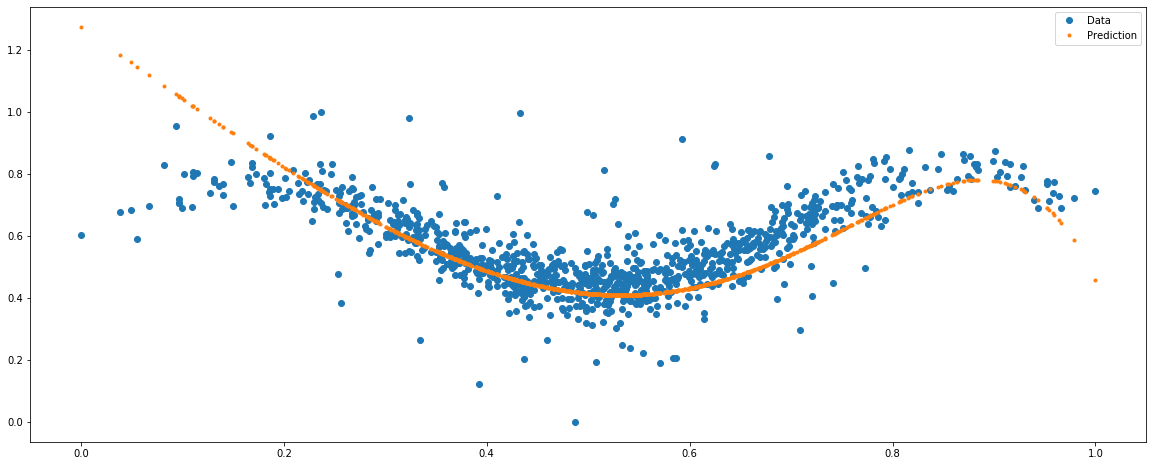

In [168]:
y_pred = predict(X_a, theta)
plt.plot(X, y, 'o', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

In [0]:
degrees = [1,2,5,25,50]

In [0]:
from sklearn.model_selection import train_test_split

# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

18.896184682609892
12.237109635557282
9.903246380963457
10.267834575050742
10.455278666473367


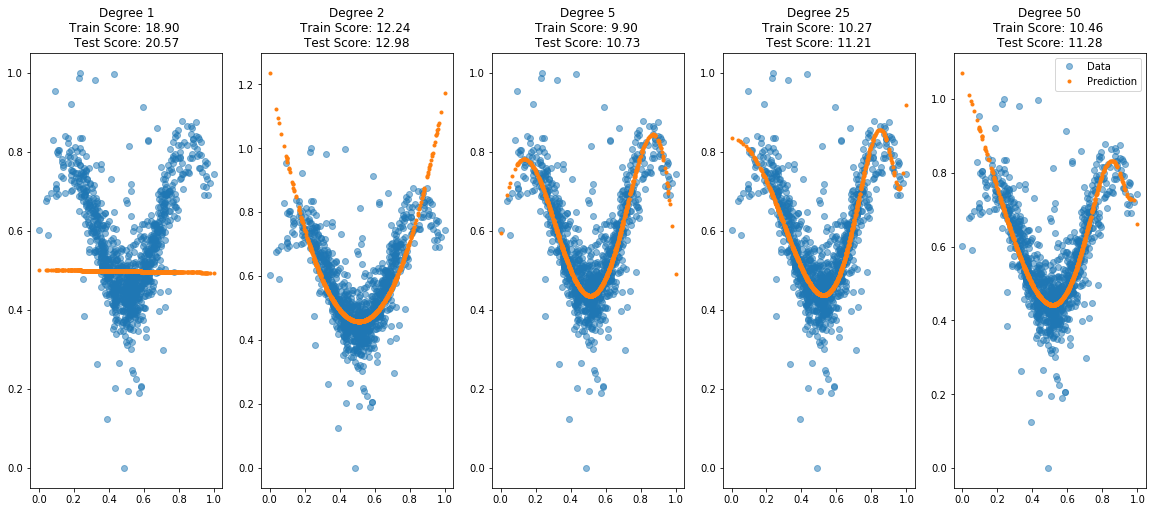

In [171]:

for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
  X_all = polynomial_features.fit_transform(X)
  X_a_train = polynomial_features.fit_transform(X_train)
  X_a_test = polynomial_features.fit_transform(X_test)
  
  theta = custom_regression(X_a_train, y_train, objective_function=objective_function, loss_function=mape, iters = 20)
  y_pred_test = predict(X_a_test, theta)
  y_pred_train = predict(X_a_train, theta)
  test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
  train_score = objective_function(theta=theta, X=X_a_train, y=y_train)
  
  y_pred = predict(X_all, theta)
  
  ax = plt.subplot(1, len(degrees), i + 1)

  ax.plot(X, y, 'o', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = True)
  #ax.plot(X, X*coef.T, 'b--', label = 'True model')
  ax.plot(X, y_pred, '.', label = 'Prediction')
  plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))
plt.legend()

18.896184682609892
12.237109635557282
9.901169412473829
10.042819859189848
10.258037880752406
CPU times: user 740 ms, sys: 418 ms, total: 1.16 s
Wall time: 664 ms


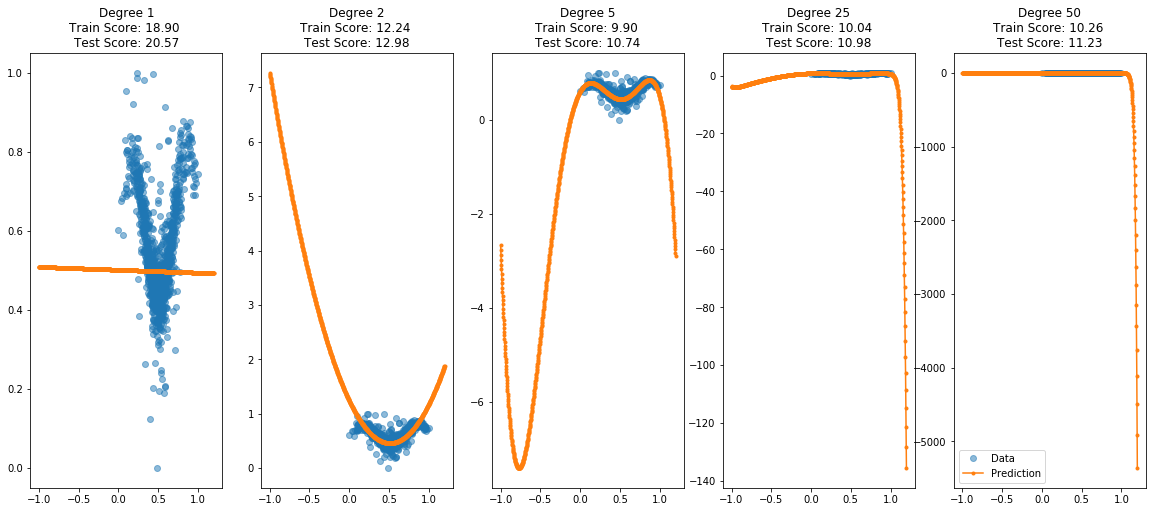

In [172]:
%%time
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
  X_all = polynomial_features.fit_transform(X)
  X_a_train = polynomial_features.fit_transform(X_train)
  X_a_test = polynomial_features.fit_transform(X_test)
  
  theta = custom_regression(X_a_train, y_train, objective_function=objective_function, loss_function=mape, iters = 25)
  y_pred_test = predict(X_a_test, theta)
  y_pred_train = predict(X_a_train, theta)
  test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
  train_score = objective_function(theta=theta, X=X_a_train, y=y_train)
  
  xx = np.linspace(-1,1.2,1000).reshape(1000,1)
  xxa = polynomial_features.fit_transform(xx) # X_all
  y_pred = predict(xxa, theta)
  
  ax = plt.subplot(1, len(degrees), i + 1)

  ax.plot(X, y, 'o', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = True)
  #ax.plot(X, X*coef.T, 'b--', label = 'True model')
  ax.plot(xx, y_pred, '.-', label = 'Prediction')
  plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))
plt.legend()

Text(0.5, 1.0, 'Degree 50\nTrain Score: 10.26 \nTest Score: 11.23')

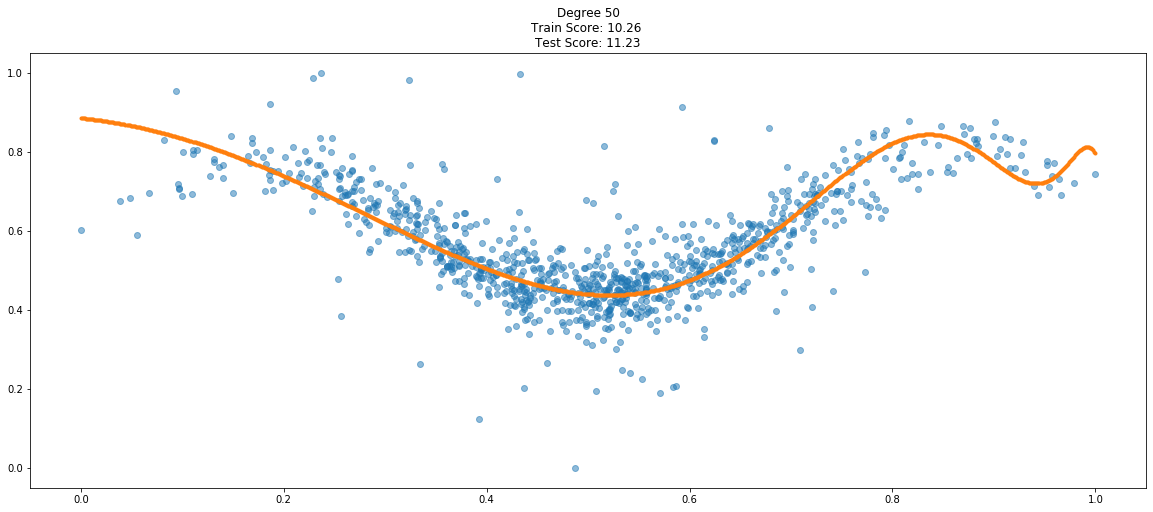

In [173]:
xx = np.linspace(0,1,1000).reshape(1000,1)
xxa = polynomial_features.fit_transform(xx) # X_all
y_pred = predict(xxa, theta)

ax = plt.subplot(1, 1,1)

ax.plot(X, y, 'o', alpha = 0.5, label = 'Data')
ax.autoscale(enable = True)
#ax.plot(X, X*coef.T, 'b--', label = 'True model')
ax.plot(xx, y_pred, '.-', label = 'Prediction')
plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))

## Evaluate result

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [0]:
class CustomRegression:
  def __init__(self, loss_function=mape, objective_function=objective_function, beta = BETA):
    self.theta = None
    self.loss_function = loss_function
    self.objective_function = objective_function
    self.beta = beta
  
  def predict(self, X):
    return predict(X, self.theta)
  
  def score(self, X, y):
    return self.objective_function(theta=self.theta, X=X,y=y,loss_function=self.loss_function)
  
  def fit(self, X, y):
    if type(self.theta) == type(None):
      self.theta = np.ones_like(X[0])    
    self.theta = custom_regression(X, y, self.objective_function, self.loss_function, init = self.theta, verbose = False, beta = self.beta)
    return self.score(X, y) 

In [0]:
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree = n)
  regression = CustomRegression()

  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression

  pipeline.fit(X_train, y_train)
  # Evaluate the models using crossvalidation instead of test_set
  scores = cross_val_score(pipeline, X_train, y_train,
                               scoring=None, cv=10)
  
  test_scores = pipeline.score(X_test, y_test)
  
  y_pred = pipeline.predict(X)
  

  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, 'o', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  #ax.plot(X, X*coef.T, 'b--', label = 'True model')
  ax.plot(X, y_pred, '.', label = 'Prediction')
  plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(degrees[i], scores.mean(), scores.std(), test_scores))
plt.legend()

TypeError: ignored

> <ipython-input-175-05529751bd3c>(17)fit()
     14   def fit(self, X, y):
     15     if type(self.theta) == type(None):
     16       self.theta = np.ones_like(X[0])
---> 17     self.theta = custom_regression(X, y, self.objective_function, self.loss_function, init = self.theta, verbose = False, beta = self.beta)
     18     return self.score(X, y)



In [0]:
plt.hist(theta, bins = 50)

In [0]:
%%time
betas = np.linspace(0,5,100)
test_scores = []
for i,n in enumerate(betas):
  polynomial_features = PolynomialFeatures(degree = 2)
  regression = CustomRegression(beta = n)

                       ("linear_regression", regression)]) # apply linear regression

  pipeline.fit(X_train, y_train)
  # Evaluate the models using crossvalidation instead of test_set
  scores = cross_val_score(pipeline, X_train, y_train,
                               scoring=None, cv=10)
  
  test_scores.append(pipeline.score(X_test, y_test))


In [0]:
plt.plot(betas, test_scores)

In [0]:
q = p = np.linspace(1e-5,1,1000)
H = -p*np.log(p)
Hpq = -p*np.log(q)
Hplq = p*np.log(p/q) 
gini = p*(1-p)


In [0]:

#plt.plot(p,Hpq, label = '$H(pq)$')
#plt.plot(p,Hplq, label = '$H(p|q)$')
plt.figure(figsize = (4,4), dpi = 175)
plt.plot(p,gini,label = 'Gini')
#plt.plot(p,H, label = 'Entropy')
#plt.title('Gini')
plt.legend()